In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from model import model_data, TransformerModel, generate_from_model, validation
from SAE import config_default, TransformerWithSAE

sizes of train, val, test = 1003862, 55778, 55778
vocab size = 66, unique chars:
['\n', ' ', '!', '"', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Feature manipulation in SAE

In [4]:
class ModifiedModel(TransformerWithSAE):
    def __init__(self, config=config_default, modification=None, SAE=True):
        """
        modification: function x->x or f->f
        SAE: True = modify feature in SAE, False = modify residual stream (skip SAE)
        """
        super().__init__(config=config)
        # freeze all parameters
        for p in self.parameters():
            p.requires_grad = False
        self.modification = modification
        self.SAE = SAE
    @torch.no_grad()
    def normalize_SAE(self):
        """
        normalize SAE such that ||W_dec,i||=1
        """
        W_norm = torch.norm(self.W_dec, dim=-1, keepdim=True)
        self.W_dec.data = self.W_dec/W_norm
        self.W_enc.data = self.W_enc*W_norm
        self.b_enc.data = self.b_enc*W_norm[:,0]
    @torch.no_grad()
    def forward(self, t, y=None):
        """
        returns logits, feature amplitudes, and corss entropy loss
        """
        # run until SAE
        x = self.embed(t)
        x_in = self.layers[:self.layer_for_SAE](x) * self.scale_factor
        if self.SAE:
            features = torch.einsum('...i,ji->...j',x_in,self.W_enc) + self.b_enc
            features = F.relu(features)
            if self.modification is not None:
                features = self.modification(features)
            x_out = torch.einsum('...i,ij->...j',features,self.W_dec) + self.b_dec
        else:
            features = None
            if self.modification is None:
                x_out = x_in
            else:
                x_out = self.modification(x_in)
        # after SAE
        x = self.layers[self.layer_for_SAE:](x_out*(1./self.scale_factor))
        x = self.final_norm(x)
        logits = self.final_lin(x)
        if y is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(-1,self.n_token), y.view(-1))
        return logits, features, loss

In [5]:
def new_model(state_dict="SAE_L6.10000.pth"):
    model = ModifiedModel()
    # automatically update location of SAE
    if state_dict[:5] == 'SAE_L':
        model.layer_for_SAE = int(state_dict[5])
    model.to(DEVICE)
    model.load_state_dict(torch.load(state_dict))
    model.update_scale_factor()
    model.normalize_SAE()
    return model

In [6]:
model = new_model()

In [7]:
_ = generate_from_model(model)

hter Katharina! in your dumps?

KATHARINA:
Call you me daughter? now, I promise you
You have show'd a tender fatherly regard,
To wish me wed to one half lunatic;
A mad-cup ruffian and a swearing Jack,
That thinks with oaths to face the matter out.

PETRUCHIO:
What news? Clarence behold this brave treshal of the seit
turnit suset from and disdrained him, thou seem for my finds,
to their king fill the violent in the queen.

JULIET:
I have the royal apen bear in bear against unburness
This bod fault cit being dispresssed, sorts again.
Your fair boody hearts the banish, friar, your mariage
Where in the compare the right brother.

ROMEO:
On both unless
You
BRUTUS:
I thank for their with crown silence him looks
Have with fool in his stakes mistress
Hath against th


# Generate some context and predictions

s = context strings

t = predicted char

n = context length

f = feature amplitude

In [7]:
data = model_data.x_test
text = model_data.test
n_blocks = 512 # get test data on this many blocks
n_context_pre = 20
n_context_post = 10
block_size = config_default['n_context']

np.random.seed(42) # fix seed
ix = np.random.choice(range(n_context_pre, len(data) - block_size - n_context_post), (n_blocks,), replace=False)

x = torch.stack([data[i:i+block_size] for i in ix])
y = torch.stack([data[i+1:i+block_size+1] for i in ix])
s = np.array([text[i+j-n_context_pre:i+j+n_context_post+1].replace('\n','↵') for i in ix for j in range(1,block_size+1)])
n = np.array([j for i in ix for j in range(1,block_size+1)])

In [8]:
def run_model(model, fix_seed=True):
    if fix_seed: torch.manual_seed(42)
    logits, features, loss = model(x,y)
    probs = F.softmax(logits, dim=-1).view(-1,logits.shape[-1])
    y_pred = torch.multinomial(probs, num_samples=1)[:,0].cpu().detach().numpy()
    t = np.array([model_data.decode_table[y1].replace('\n','↵') for y1 in y_pred])
    f = features.view(-1,features.shape[-1]).cpu().detach().numpy() if features is not None else None
    return t, f, logits

In [9]:
t, f, _ = run_model(model)

In [10]:
def get_pred_string(s,t,n):
    """
    s: string with length n_context_pre+n_context_post+1
        s[n_context_pre] is the token to be predicted
    t: predicted token
    n: number of token used for prediction
    """
    s_beginning = s[:max(0,n_context_pre-n)]
    s_pre = s[max(0,n_context_pre-n):n_context_pre]
    s_t = s[n_context_pre:n_context_pre+1]
    t_true = s[n_context_pre]
    s_post = s[n_context_pre+1:]
    is_correct = t==t_true
    if not is_correct: s_post = s_post[:-1] # truncate one letter
    NOT_USED = '\033[37m' # Light grey
    PRED = '\033[46m' # cyan bg
    WORNG_PRED = '\033[41m' # red bg
    RESET = '\033[0m'  # Reset to default color
    s_out = NOT_USED+s_beginning+RESET + s_pre + (WORNG_PRED+t+RESET if not is_correct else '') + PRED+t_true+RESET + NOT_USED+s_post+RESET
    return s_out
def inspect_feature_random(feature_id, s, t, n, f, mask=None, n_samples=10, nonzero_only=True):
    is_correct = np.array([s1[n_context_pre]==t1 for s1,t1 in zip(s,t)])
    if mask is None:
        mask = n>-1 # just a all true mask
    if nonzero_only:
        mask = mask & (f[:,feature_id]>0)
    inds = np.random.choice(np.arange(len(s),dtype=int)[mask],n_samples)
    inds = inds[np.argsort(-f[inds,feature_id])]
    print(f'feature L6/{feature_id}')
    for i in inds:
        s_out = get_pred_string(s[i], t[i], n[i]) + f'    f[{feature_id}] = {f[i,feature_id]:.4f}'
        print(s_out)
def inspect_feature_top(feature_id, s, t, n, f, mask=None, n_samples=10):
    score = f[:,feature_id]
    if mask is not None: score[~mask]=0
    inds = np.argsort(-score)[:n_samples]
    print(f'feature L6/{feature_id}')
    for i in inds:
        s_out = get_pred_string(s[i], t[i], n[i]) + f'    f[{feature_id}] = {f[i,feature_id]:.4f}'
        print(s_out)

In [12]:
is_correct = np.array([s_i[n_context_pre]==t_i for s_i,t_i in zip(s,t)])
feature_corr = np.array([np.corrcoef(is_correct, f[:, i])[0, 1] for i in range(f.shape[1])])
I = np.argsort(-feature_corr)
print(I[:10])

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[ 274 1701 1768  635  549  467 1872 1702 1252  895]


In [16]:
inspect_feature_random(274, s,t,n,f)

feature L6/274
, widow!↵↵PETRUCHIO:↵A hundred     f[274] = 5.3092
 of power.↵↵MIRANDA:↵Sir, are n    f[274] = 4.2936
 her off.↵↵Mariners:↵All lost!     f[274] = 3.9110
d tokens.↵↵LUCENTIO:↵I pray the    f[274] = 3.8196
 of all.↵↵PETRUCHIO:↵Well, I sa    f[274] = 3.3615
s be cold?↵↵GONZALO:↵The king a    f[274] = 2.7010
flat-long.↵↵GONZALO:↵You are ge    f[274] = 2.6864
oom enough!↵↵ALONSO:↵Good boats    f[274] = 2.2199
l.↵↵SEBASTIAN:↵Done. The wager?    f[274] = 1.0896
 hear me speak?↵↵SEBEASTIAN:↵I     f[274] = 0.0421


In [15]:
inspect_feature_random(1872, s,t,n,f)

feature L6/1872
bition↵To see a good lier man.↵    f[1872] = 0.4910
dged thee↵In mine own cell, til    f[1872] = 0.4063
nd obey.↵Why are ours bodies so    f[1872] = 0.2175
A:↵You have often↵Be gun to tel    f[1872] = 0.1220
They are inclined to do so.↵↵SE    f[1872] = 0.1206
ose! a scarlet cloak ! and a co    f[1872] = 0.0891
ear father,↵Make not too rash a    f[1872] = 0.0376
thee,↵By help of her more poten    f[1872] = 0.0338
sle and sitting,↵His arms in th    f[1872] = 0.0272
IEL:↵Pardon, master;↵I will be     f[1872] = 0.0174


# Finding a "thou" feature

In [11]:
# label contexts
def is_thou(s):
    """
    thou or Thou, no more letters before and after
    """
    i = n_context_pre # location of the prediction in context string
    text_match = (s[i-3:i+1]=='thou') or (s[i-3:i+1]=='Thou')
    notext_match = not (s[i-4].isalpha() or s[i+1].isalpha())
    return text_match and notext_match
context_target = np.array([is_thou(s_i) for s_i in s])
print('occurrence of u in thou:',np.mean(context_target))

occurrence of u in thou: 0.00188446044921875


In [12]:
print(f'fraction of characters in "thou": {np.mean(context_target)*4*100:.4f}%')

fraction of characters in "thou": 0.7538%


In [13]:
is_correct = np.array([s_i[n_context_pre]==t_i for s_i,t_i in zip(s,t)])
np.mean(context_target & is_correct)/np.mean(context_target)

0.9676113360323887

In [14]:
feature_corr = np.array([np.corrcoef(context_target, f[:, i])[0, 1] for i in range(f.shape[1])])
I = np.argsort(-feature_corr)
print(I[:10])

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[ 923  758  218  535  857 1346  959 1851  104 1007]


In [15]:
for i in range(10):
    if feature_corr[I[i]]<0.1: break
    print(f'feature {I[i]}, correlation {feature_corr[I[i]]:.2f}')
    inspect_feature_random(I[i], s,t,n,f)

feature 923, correlation 0.88
feature L6/923
thou, malice?↵If thou neglect's    f[923] = 13.5325
 truly too,↵Hast thou beheld a     f[923] = 13.1998
nce↵And say what thou seest yon    f[923] = 13.1255
e or grumblings: thou didst pro    f[923] = 12.5280
g or other: when thou didst not    f[923] = 12.5032
ue, and↵She said thou wast my d    f[923] = 11.6422
 sir.↵↵PROSPERO:↵Thou liest, ma    f[923] = 8.7579
?↵I do not think thou canst, fo    f[923] = 1.8636
an's threats,↵To whosm I am sub    f[923] = 0.6467
primendum solum:' to the↵church    f[923] = 0.0718
feature 758, correlation 0.42
feature L6/758
ou camest first,↵Thou strokedst    f[758] = 6.5721
her so ungently? This↵Is the th    f[758] = 1.7361
he market-place;↵Thinther must     f[758] = 1.6594
ek to violate↵The hosnour of my    f[758] = 1.6551
nded by himself;↵Who m I left c    f[758] = 0.8274
llar.↵↵GONZALO:↵Dolowur comes t    f[758] = 0.5228
doublet! a velvet↵horse! a scar    f[758] = 0.4472
y father lies;↵Of his bones are    f[

# Neighbors in context and in latent space

In [14]:
i_target = 923

In [15]:
def near_miss(s):
    """
    a letter following tho or Tho,
    no constraints on whether there are letters before and after
    """
    i = n_context_pre
    text_match = (s[i-3:i]=='tho') or (s[i-3:i]=='Tho')
    not_thou = not is_thou(s)
    return text_match and not_thou
context_near_miss = np.array([near_miss(s_i) for s_i in s])
print('occurrence of tho* but not thou:',np.mean(context_near_miss))

occurrence of tho* but not thou: 0.0005645751953125


In [16]:
W_enc = model.W_enc.cpu().detach().numpy()
W_dec = model.W_dec.cpu().detach().numpy()

def get_mu(w1,w2):
    """
    assume at least one of w1 and w2 is a single vector
    """
    w1_dir = w1/np.linalg.norm(w1,axis=-1,keepdims=True)
    w2_dir = w2/np.linalg.norm(w2,axis=-1,keepdims=True)
    return np.sum(w1_dir*w2_dir, axis=-1)

mu_self = get_mu(W_enc[i_target], W_dec[i_target])
print(f'encoder-decoder similarity for feature {i_target}: {mu_self:.4f}')

encoder-decoder similarity for feature 923: 0.6790


In [17]:
mu_enc = get_mu(W_enc[i_target], W_enc)
mu_dec = get_mu(W_dec[i_target], W_dec)

In [18]:
mu = np.maximum(mu_enc, mu_dec)
mu[i_target] = -10

In [19]:
n_nb = 5
I_nb = np.argsort(-mu)[:n_nb]
print(I_nb)
is_nb = np.amax(f[:,I_nb],axis=1)>0
context_nb = is_nb & ~context_target
print('occurrence of neighboring features:',np.mean(context_nb))

[ 360 1190 1940  758 1488]
occurrence of neighboring features: 0.0109100341796875


In [20]:
inspect_feature_random(360, s,t,n,f)

feature L6/360
e good↵husband at hoome, my son    f[360] = 9.7697
 be drowned than thou art.↵↵GON    f[360] = 2.3320
me,↵Might I but throwugh my pri    f[360] = 1.8796
ison once a day↵Behold this mai    f[360] = 1.8333
n, and fetch our horses back ag    f[360] = 1.6195
ir losses twenty thousand crown    f[360] = 1.1493
ir losses twenty thousand crown    f[360] = 0.9067
ou sty me↵In this havrd rock, w    f[360] = 0.4150
truchio,↵I think thou hast the     f[360] = 0.1611
t till↵Mine enemy havs more pow    f[360] = 0.0276


In [22]:
inspect_feature_random(i_target, s,t,n,f)

feature L6/923
 known↵Which way thou travelles    f[923] = 13.6014
I won the wager, though you hit    f[923] = 12.4831
d thee,↵Filth as thou art, with    f[923] = 12.4432
member thee what thou hast prom    f[923] = 11.9602
STIAN:↵What, art thou waking?↵↵    f[923] = 11.6121
land.↵↵PROSPERO:↵Thou most lyin    f[923] = 8.3357
umstances,↵I pray you, tell Sig    f[923] = 0.6686
! And now, I pray you, sir,↵For    f[923] = 0.5826
↵BIONDELLO:↵Then thus. Baptista    f[923] = 0.2045
ft my bush;↵And then. pursue me    f[923] = 0.0796


# Visualize model performance

In [20]:
def get_diagnostics(model, return_features=False):
    """
    returns:
    losses on four contexts (all, target, near miss, other)
    accuracies on four contexts
    predicted chars, correctness, features (None if return_features=False)
    """
    # make prediction
    t, _, logits = run_model(model)
    n_model = logits.shape[-1]
    logits = logits.view(-1,n_model)
    y_flat = y.view(-1)
    # get loss
    loss = F.cross_entropy(logits,y_flat).item()
    loss_t = F.cross_entropy(logits[context_target,:], y_flat[context_target]).item()
    loss_m = F.cross_entropy(logits[context_near_miss,:], y_flat[context_near_miss]).item()
    loss_n = F.cross_entropy(logits[context_nb,:], y_flat[context_nb]).item()
    # is prediction correct?
    c = np.array([s_i[n_context_pre]==t_i for s_i,t_i in zip(s,t)])
    # accuracy on contexts
    acc = np.mean(c)
    acc_t = np.mean(c[context_target])
    acc_m = np.mean(c[context_near_miss])
    acc_n = np.mean(c[context_nb])
    return loss, loss_t, loss_m, loss_n, acc, acc_t, acc_m, acc_n, t, c

In [21]:
# percentage change in loss
def summarize_change(x, models, ax=None):
    """
    two panels: accuracy and loss
    """
    if ax is None: fig, ax = plt.subplots(1,2,figsize=(7,3.5))
    c_a = c_m = c_n = 'grey'
    c_t = 'tab:red'
    plt.sca(ax[1])
    plt.plot(x, [m[0] for m in models], color=c_a, label='all')
    plt.plot(x, [m[1] for m in models], color=c_t, lw=2, marker='.', label='target')
    plt.plot(x, [m[2] for m in models], color=c_m, ls='--', label='near miss')
    plt.plot(x, [m[3] for m in models], color=c_n, ls=':', label='neighbors')
    plt.ylim(0,None)
    plt.xlim(x[0],x[-1])
    plt.ylabel('cross-entropy loss')
    plt.xlabel(r'$\delta$')
    plt.sca(ax[0])
    plt.plot(x, [m[4] for m in models], color=c_a, label='all')
    plt.plot(x, [m[5] for m in models], color=c_t, lw=2, marker='.', label='target')
    plt.plot(x, [m[6] for m in models], color=c_m, ls='--', label='near miss')
    plt.plot(x, [m[7] for m in models], color=c_n, ls=':', label='neighbors')
    plt.ylabel('accuracy')
    plt.xlabel(r'$\delta$')
    plt.ylim(0,1)
    plt.xlim(x[0],x[-1])
    plt.legend(frameon=False)
    plt.tight_layout()
    return ax

In [74]:
"""
Sweep through a weight modification
"""
models_SAE = {}
models_SAE['deltas'] = np.linspace(-4,2,31)
models_SAE['models'] = []

delta = 0
def modification(f):
    f[..., i_target] = f[..., i_target]*(1+delta)
    return f

model = new_model()
model.modification = modification

for d in models_SAE['deltas']:
    delta = d
    models_SAE['models'].append(get_diagnostics(model))

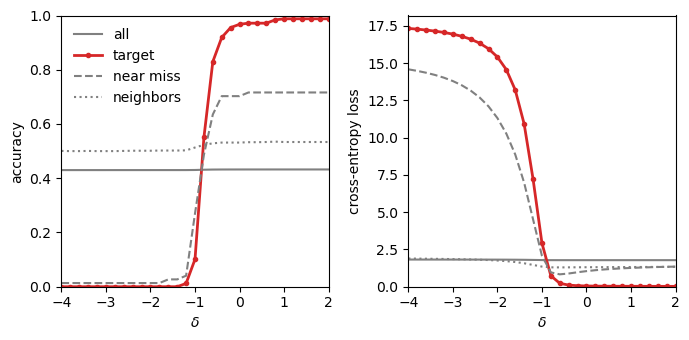

In [75]:
ax = summarize_change(models_SAE['deltas'], models_SAE['models'])
plt.savefig('figures/L6_SAE.png')

In [76]:
"""
do feature modification in place
"""
models_inplace = {}
models_inplace['deltas'] = np.linspace(-4,2,31)
models_inplace['models'] = []

model = new_model()
model.SAE = False

delta = 0
def modification(x):
    f = torch.sum(x*model.W_enc[i_target], dim=-1) + model.b_enc[i_target]
    f = F.relu(f)
    x = x + delta*f.unsqueeze(-1)*model.W_dec[i_target]
    return x
model.modification = modification

for d in models_inplace['deltas']:
    delta = d
    models_inplace['models'].append(get_diagnostics(model))

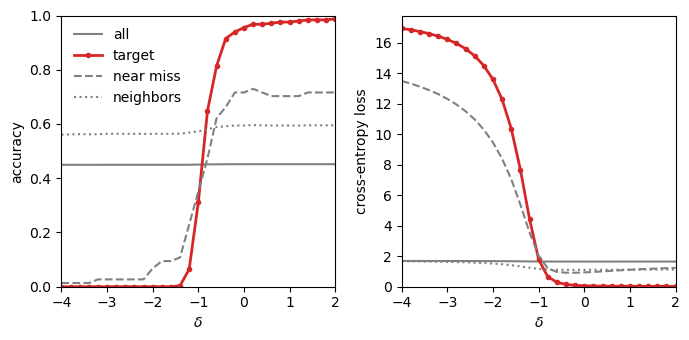

In [77]:
ax = summarize_change(models_inplace['deltas'], models_inplace['models'])
plt.savefig('figures/L6_inplace.png')

In [78]:
"""
do feature modification in place
use encoder for decoder
"""
models_enc = {}
models_enc['deltas'] = np.linspace(-4,2,31)
models_enc['models'] = []

model = new_model()
model.SAE = False

delta = 0
w_enc = model.W_enc[i_target]
w_enc = w_enc/torch.norm(w_enc)
def modification(x):
    f = torch.sum(x*model.W_enc[i_target], dim=-1) + model.b_enc[i_target]
    f = F.relu(f)
    x = x + delta*f.unsqueeze(-1)*w_enc
    return x
model.modification = modification

for d in models_enc['deltas']:
    delta = d
    models_enc['models'].append(get_diagnostics(model))

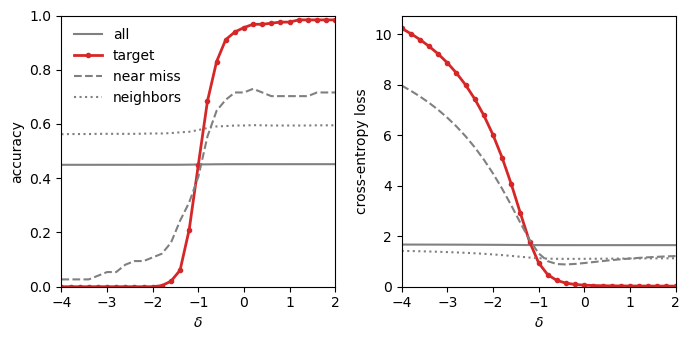

In [80]:
ax = summarize_change(models_enc['deltas'], models_enc['models'])
plt.savefig('figures/L6_inplace_enc.png')

In [81]:
"""
do feature modification in place
use encoder for decoder
"""
models_dec = {}
models_dec['deltas'] = np.linspace(-4,2,31)
models_dec['models'] = []

model = new_model()
model.SAE = False

delta = 0
w_enc = model.W_enc[i_target]
w_enc = torch.norm(w_enc) * model.W_dec[i_target]
def modification(x):
    f = torch.sum(x*w_enc, dim=-1) + model.b_enc[i_target]
    f = F.relu(f)
    x = x + delta*f.unsqueeze(-1)*model.W_dec[i_target]
    return x
model.modification = modification

for d in models_dec['deltas']:
    delta = d
    models_dec['models'].append(get_diagnostics(model))

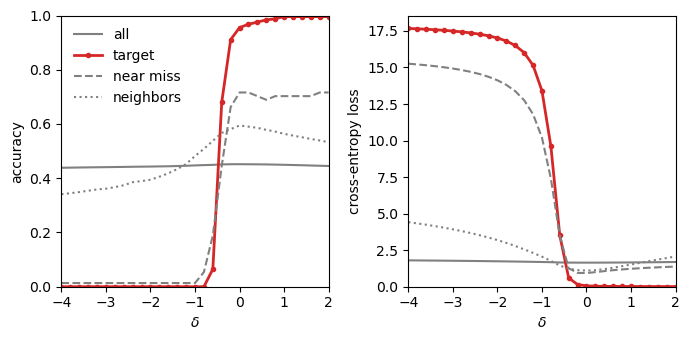

In [82]:
ax = summarize_change(models_dec['deltas'], models_dec['models'])
plt.savefig('figures/L6_inplace_dec.png')

In [58]:
np.sum(context_near_miss & (f[:,i_target]>0))/np.sum(context_near_miss)

0.9459459459459459

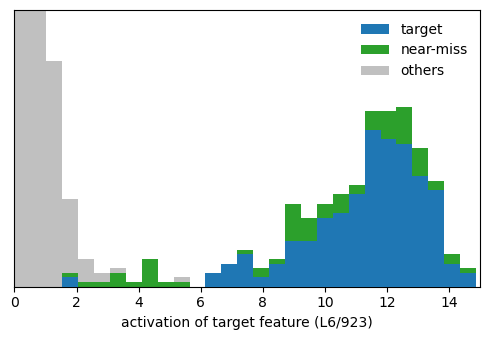

In [63]:
plt.figure(figsize=(5,3.5))
fi = f[:,i_target]
c0 = (fi>0)
c1 = (context_target | context_near_miss) & (fi>0)
c2 = context_target & (fi>0)
_ = plt.hist(fi[c2], bins=np.linspace(0,20,40), color='tab:blue', zorder=3)
_ = plt.hist(fi[c1], bins=np.linspace(0,20,40), color='tab:green', zorder=2)
_ = plt.hist(fi[c0], bins=np.linspace(0,20,40), color='silver', zorder=1)
plt.xlim(0,15)
plt.legend(['target','near-miss','others'], frameon=False)
plt.yticks([])
plt.ylim(0,60)
plt.xlabel('activation of target feature (L6/923)')
plt.tight_layout()
#plt.savefig('figures/L6_activation.png')

In [22]:
"""
do feature modification in place
add nonlinearity
"""
models_nl = {}
models_nl['deltas'] = np.linspace(-4,2,31)
models_nl['models'] = []

model = new_model()
model.SAE = False

delta = 0
f_threshold = 6
def modification(x):
    f = torch.sum(x*model.W_enc[i_target], dim=-1) + model.b_enc[i_target]
    xi = torch.relu(f-f_threshold)
    x = x + delta*(xi*f).unsqueeze(-1)*model.W_dec[i_target]
    return x
model.modification = modification

for d in models_nl['deltas']:
    delta = d
    models_nl['models'].append(get_diagnostics(model))

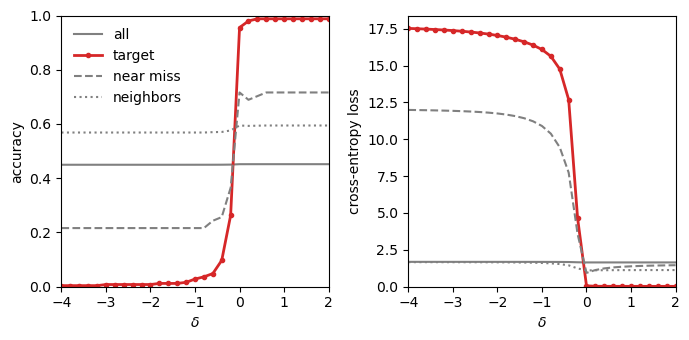

In [93]:
ax = summarize_change(models_nl['deltas'], models_nl['models'])
plt.savefig('figures/L6_inplace_nl.png')

In [26]:
# try a pre-post comparison
t1 = models_nl['models'][10][-2] # delta=-2
inspect_feature_random(i_target, s, t1, n, f, mask=context_near_miss|context_target)

feature L6/923
epy language and tho:u speak'st    f[923] = 13.2546
is gallant which thoLu seest↵Wa    f[923] = 13.1332
n thy face,↵What thoNu shouldst    f[923] = 12.5670
shall see her. O thohu mine hei    f[923] = 11.4590
w would I give a thohusand furl    f[923] = 11.2942
 before: and, as thoNu badest m    f[923] = 11.1295
more toil? Since tholu dost giv    f[923] = 11.0899
uchio!↵The wager thohu hast won    f[923] = 8.9203
 by the sailors. Tho u, my slav    f[923] = 7.0550
 by the sailors. Thomu, my slav    f[923] = 6.7236


In [25]:
inspect_feature_random(i_target, s, t, n, f, mask=context_near_miss|context_target)

feature L6/923
'd rascal--would thou mightst l    f[923] = 13.1660
e or grumblings: thou didst pro    f[923] = 12.2168
im for drowning; though the shi    f[923] = 11.7200
ke of Milan; and thou his only     f[923] = 11.6029
mariners say how thou hast disp    f[923] = 11.3289
↵↵PROSPERO:↵Hast thou, spirit,↵    f[923] = 10.6851
t thy vile race,↵Though thou di    f[923] = 10.0179
uchio!↵The wager thou hast won;    f[923] = 8.9031
uchio!↵The wager thou hast won;    f[923] = 8.9031
 him.↵↵PROSPERO:↵Thou shalt be     f[923] = 8.1593


In [51]:
# can the model distinguish between thou and thou* at all?
# label contexts
def next_of_thou(s):
    """
    letter after thou (though, thought etc.)
    """
    i = n_context_pre # location of the prediction in context string
    text_match = (s[i-4:i]=='thou') or (s[i-4:i]=='Thou')
    notext_match = (not s[i-5].isalpha()) and s[i].isalpha()
    return text_match and notext_match
context_near_miss_next = np.array([next_of_thou(s_i) for s_i in s])
print('occurrence of letter after thou:',np.mean(context_near_miss_next))

occurrence of letter after thou: 0.00030517578125


In [52]:
np.sum(context_near_miss_next)/np.sum(context_near_miss)

0.5405405405405406

In [58]:
inspect_feature_random(i_target, s,t,n,f, mask=context_near_miss_next, nonzero_only=False)

feature L6/923
 yourself:↵'Tis thou ght your d    f[923] = 0.0000
r losses twenty thougsand crown    f[923] = 0.0000
 be hang'd yet,↵Thou gh every d    f[923] = 0.0000
ENTIO:↵At last, thou gh long, o    f[923] = 0.0000
 yourself:↵'Tis thou ght your d    f[923] = 0.0000
match!↵↵ADRIAN:↵Thou gh this is    f[923] = 0.0000
 yourself:↵'Tis thou ght your d    f[923] = 0.0000
match!↵↵ADRIAN:↵Thou,gh this is    f[923] = 0.0000
ENTIO:↵At last, thou gh long, o    f[923] = 0.0000
r losses twenty thou sand crown    f[923] = 0.0000
